In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from IPython.display import clear_output

In [2]:
signals = np.load("signals.npy", allow_pickle=True)
masks = np.load("masks.npy", allow_pickle=True)
sample_rate = 500

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

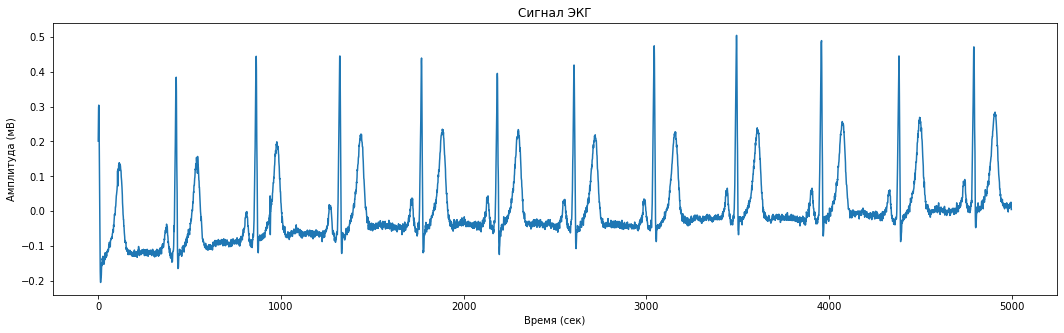

In [5]:
plt.figure(figsize=(18, 5))
plt.title("Сигнал ЭКГ")
plt.xlabel("Время (сек)")
plt.ylabel("Амплитуда (мВ)")
plt.plot(signals[0])
pass

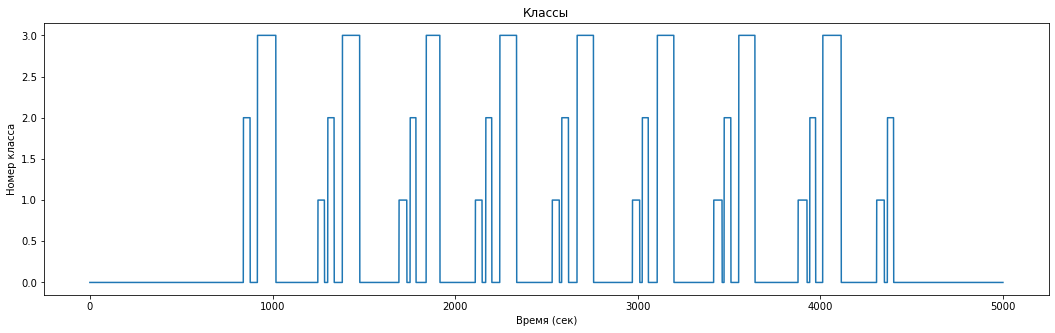

In [6]:
plt.figure(figsize=(18, 5))
plt.title("Классы")
plt.xlabel("Время (сек)")
plt.ylabel("Номер класса")
plt.plot(masks[0])
pass

In [7]:
# Вспомогательные функции, превращающие маску в сегментацию

v_to_del = {1:'p', 2:'qrs', 3:'t'}

def remove_small(signal):
    max_dist = 12
    last_zero = 0
    for i in range(len(signal)):
        if signal[i] == 0:
            if i - last_zero < max_dist:
                signal[last_zero:i] = 0
            last_zero = i

def merge_small(signal):
    max_dist = 100
    lasts = np.full(signal.max() + 1, -(max_dist+1))
    for i in range(len(signal)):
        m = signal[i]
        if i - lasts[m] < max_dist and m > 0:
            signal[lasts[m]:i] = m
        lasts[m] = i

def mask_to_delineation(mask):
    merge_small(mask)
    remove_small(mask)
    delineation = {'p':[], 'qrs':[], 't':[]}
    i = 0
    mask_length = len(mask)
    while i < mask_length:
        v = mask[i]
        if v > 0:
            delineation[v_to_del[v]].append([i, 0])
            while i < mask_length and mask[i] == v:
                delineation[v_to_del[v]][-1][1] = i
                i += 1
            t = delineation[v_to_del[v]][-1]
        i += 1
    return delineation

In [8]:
mask_to_delineation(masks[0])

{'p': [[1249, 1284],
  [1693, 1735],
  [2111, 2147],
  [2532, 2570],
  [2971, 3010],
  [3416, 3461],
  [3878, 3926],
  [4308, 4349]],
 'qrs': [[841, 877],
  [1303, 1337],
  [1754, 1785],
  [2168, 2200],
  [2584, 2620],
  [3025, 3057],
  [3473, 3509],
  [3942, 3973],
  [4367, 4400]],
 't': [[918, 1018],
  [1383, 1477],
  [1842, 1916],
  [2245, 2336],
  [2668, 2757],
  [3107, 3197],
  [3553, 3641],
  [4013, 4113]]}

In [9]:
wave_type_to_color = {
    "p": "yellow",
    "qrs": "red",
    "t": "green"
}

def plot_signal_with_mask(signal, mask):
    plt.figure(figsize=(18, 5))
    plt.title("Сигнал с маской")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда (мВ)")
    x_axis_values = np.linspace(0, len(signal) / sample_rate, len(signal))
    plt.plot(x_axis_values, signal, linewidth=2, color="black")
    
    delineation = mask_to_delineation(mask)
    for wave_type in ["p", "qrs", "t"]:
        color = wave_type_to_color[wave_type]
        for begin, end in delineation[wave_type]:
            begin /= sample_rate
            end /= sample_rate
            plt.axvspan(begin, end, facecolor=color, alpha=0.5)

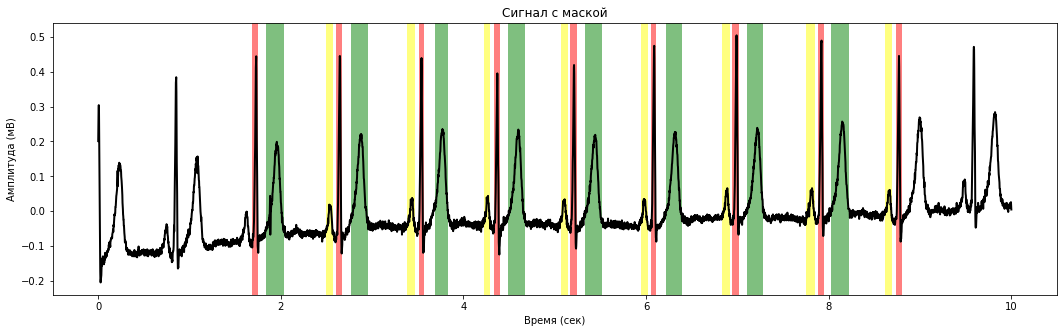

In [10]:
plot_signal_with_mask(signals[0], masks[0])

In [11]:
from sklearn.model_selection import train_test_split

signals_train, signals_test, masks_train, masks_test = \
    train_test_split(signals, masks, random_state=42)

In [12]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, signals, masks):
        self._signals = torch.FloatTensor(np.expand_dims(signals, axis=1))
        self._masks = torch.LongTensor(masks)
        self._sub_len = 4000

    def __len__(self):
        return len(self._signals)

    def __getitem__(self, i):
        shift = np.random.randint(0, 1000)
        return self._signals[i, :, shift:shift+self._sub_len].to(device), \
            self._masks[i, shift:shift+self._sub_len].to(device)

In [13]:
def get_loader(signals, masks, batch_size=32):
    dataset = SegmentationDataset(signals, masks)
    return DataLoader(dataset, batch_size=batch_size)

In [14]:
train_loader = get_loader(signals_train, masks_train, 8)
val_loader = get_loader(signals_test, masks_test, 8)

In [15]:
import torch.nn.functional as F

def get_loss(model, X_batch, y_batch):
    logits = model(X_batch)
    logits = logits[:, :, 1000:-1000]
    y_batch = y_batch[:, 1000:-1000]
    return F.cross_entropy(logits, y_batch).mean()

In [16]:
class Drawer():
    def __init__(self):
        self._train = []
        self._val = []
    
    def add(self, train_loss, val_iou):
        self._train.append(train_loss)
        self._val.append(val_iou)
        
    def plot(self):
        epochs = range(1, 1 + len(self._train))
        plt.figure(figsize=(10, 8))
        plt.title('train/val loss')
        plt.xlabel('Эпоха')
        plt.ylabel('Loss')
        plt.plot(epochs, self._train)
        plt.plot(epochs, self._val)
        plt.legend(["train", "val"])
        plt.show()

In [17]:
import time

def fit(model, train_loader, val_loader, optimizer, loss_function, num_epochs=None):
    train_losses = []
    val_losses = []
    drawer = Drawer()
    min_loss = 1e6
    min_loss_index = 0
    epoch = 0
    
    while num_epochs is None or epoch < num_epochs:
        start_time = time.time()
        model.train()
        for X_batch, y_batch in train_loader:
            loss = loss_function(model, X_batch, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.cpu().data.numpy())

        model.eval()
        for X_batch, y_batch in val_loader:
            loss = get_loss(model, X_batch, y_batch)
            val_losses.append(loss.cpu().data.numpy())
            
        train_loss = np.mean(train_losses[-len(train_loader):])
        val_loss = np.mean(val_losses[-len(val_loader):])
        print(len(train_loader), len(val_loader))
        drawer.add(train_loss, val_loss)
        
        clear_output(True)
        drawer.plot()
        print("Epoch {} took {:.3f}s".format(epoch + 1, time.time() - start_time))
        print("training loss: \t{:.6f}".format(train_loss))
        print("validation loss: \t{:.6f}".format(val_loss))
        
        if val_loss < min_loss - 1e-5:
            min_loss = val_loss
            min_loss_index = epoch
        elif epoch - min_loss_index >= 10:
            break
        
        epoch += 1

In [18]:
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoderLayer, TransformerEncoder
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, num_classes: int, n_channels: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_encoder = TransformerEncoder(TransformerEncoderLayer(d_model, nhead, d_hid, dropout), nlayers)
        self.encoder = nn.Linear(n_channels, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, num_classes)


    def forward(self, src: Tensor) -> Tensor:
        src = src.permute((2, 0, 1))
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        output = output.permute((1, 2, 0))
        return output

In [19]:
model = TransformerModel(d_model=64, nhead=2, d_hid=512, nlayers=3,
                         num_classes=4, n_channels=1, dropout=0.5)
optimizer = torch.optim.Adam(model.parameters())

In [20]:
print(sum(p.numel() for p in model.parameters()))

249412


In [21]:
model = model.to(device)

In [22]:
optimizer = torch.optim.Adam(model.parameters())

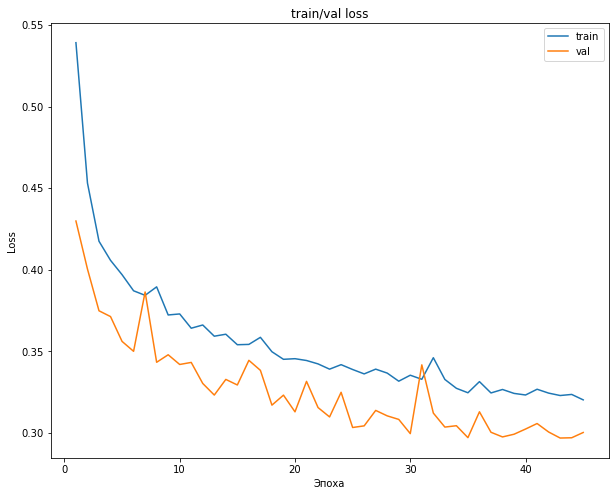

Epoch 45 took 220.510s
training loss: 	0.320178
validation loss: 	0.300180


KeyboardInterrupt: 

In [26]:
num_epochs = 10 # increase me
fit(model, train_loader, val_loader, optimizer, get_loss, num_epochs)

In [27]:
torch.jit.save(torch.jit.script(model), "model_transformer.pt")

In [27]:
model = model.cpu()

In [28]:
def get_probs(signal):
    signal = np.expand_dims(signal, axis=(0, 1))
    signal = torch.FloatTensor(signal)
    mask = model(signal)[0].data.numpy()
    mask = np.exp(mask)
    return mask / np.sum(mask, axis=0)

def get_mask(signal):
    signal = np.expand_dims(signal, axis=(0, 1))
    signal = torch.FloatTensor(signal)
    mask = model(signal)[0]
    mask = mask.argmax(axis=0)
    return mask.data.numpy()

def plot_test_sample(signal):
    mask = get_mask(signal)
    plot_signal_with_mask(signal, mask)

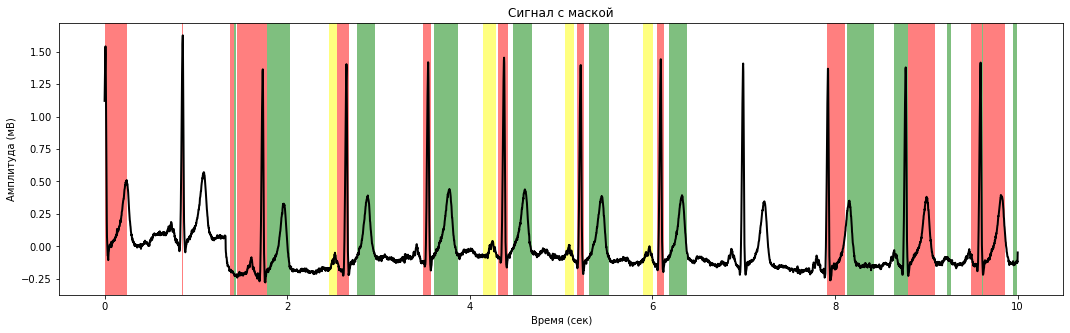

In [29]:
plot_test_sample(signals[1])